# Machine Learning for Equipment Failure Prediction and Equipment Maintenance (PM)
For more information on the topic please see the following article.

https://medium.com/swlh/machine-learning-for-equipment-failure-prediction-and-predictive-maintenance-pm-e72b1ce42da1

Published July 2020, Greatly revised February 2021. Augmented and improved again in August 2022.

In this notebook, I walk through a predictive maintenance problem in great detail. These types of issues can be tricky for several reasons. The first six sections deal with building a model. The last sections deal with evaluating model effectiveness and ensuring it will be effective when deployed in production.

When it comes to dealing with machines that require periodic maintenance, there are generally three possible outcomes.

One, you can maintain a machine too frequently. In other words, the machine gets maintenance when it is not required. In this scenario, you are throwing money out the window, wasting resources providing unnecessary maintenance. For example, you could change the oil in your car every single day. This is not optimal, and you will waste a lot of money on unnecessary maintenance.

Two, you don’t maintain your machine frequently enough. Failing to maintain a machine means that the machine will break while operating. Here, the costs could be substantial. Not only do you have the repair costs, but also costs associated with lost production. If a machine on the assembly line goes down, the line cannot produce anything. No production means lost profit. Also, you will incur legal and medical costs if injuries occurred as a result of the failure.

Three, a machine is maintained when it needs maintenance. This is obviously the better alternative of the three. Note, that that there is still a cost associated with timely maintenance.

So, we need to maintain machines when they need maintenance, right? Unfortunately, this is easier said than done. Fortunately, we can use predictive maintenance (PM) to predict when machines need maintenance.

I should also mention that most machines come with manufacturer recommendations on maintenance. The problem with manufacturer recommendations is that they represent an average. For example, cars on average need an oil change every 3,000 miles, but how frequently does your car need an oil change? It may be more or less than 3,000 miles depending on several factors, including where your drive, how you drive, and how frequently you drive.

Predictive maintenance (PM) can tell you, based on data, when a machine requires maintenance. An effective PM program will minimize under and over-maintaining your machine. For a large manufacturer with thousands of machines, being precise on machine maintenance can save millions of dollars every year.

In this article, I will examine a typical Predictive Maintenance (PM) use case. As I walk through this example, I will describe some of the issues that arise with PM problems and suggest ways to solve them.

An important note about the data used in this exercise. It is entirely fake. I created the data based on my experience of dealing with these types of problems. Although it is entirely artificial, I believe the data and use case is very realistic and consistent with many real PM problems.

The firm in our use case provided a sample of data that includes 421 machines that failed over two years. They spent 11.766M dollars on maintenance, most of which came from running machines until failure.

Here is a summary of the maintained or repaired machines over the last two years.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fUKUEUeqgIYU9xlxj4pwhw.png")

From the data above, it currently costs the firm about $28,000 per failed or maintained machine. Our goal is to lower this cost.

In the chart above, Timely Maintenance costs more than Unnecessary Maintenance. There is a good reason for this. For this machine, unnecessary maintenance means that that machine was moved off-line and checked, but the part in question showed insufficient wear to replace. Because parts were not replaced, there are no material costs, only labor.

Note that this company does very little predictive maintenance. Most of the time, they just run the machines to failure. Also, note that these machines will break in four to eight years if they don’t receive maintenance. When they fail, they must be pulled off-line and repaired.

Our goal is to show the firm how a Predictive Maintenance program can save them money. To do this, we will build a predictive model that predicts machine failure within 90 days of actual failure. Note that an appropriate failure window will always depend on the context of the problem. If a machine breaks without maintenance in 6 months, a three-month window makes no sense. Here, where a machine will run between 4 to 6 years without maintenance, a 90-day window is reasonable.

Our objective is to develop a solution that will lower the costs of failure. Again, it currently costs the firm about 28,000 per machine. We will attempt to reduce this cost.

Note that I developed this exercise in Watson Studio on the IBM Cloud. If you have issues running the notebook, please set up a free account on IBM Cloud and try it there. https://www.ibm.com/cloud/watson-studio

### Table of Contents

1. Setup

2. Data Exploration

3. Data Transformation and Feature Engineering

4. Dealing with the Small Number of Failures

    4.1 Expand the Failure Window
    
    4.2 Create Testing, Training and Validation Groups
    
    4.3 SMOTE the Training Data

5. More Data Transformations and Feature Engineering

6. Build the Model on the Balanced Data Set

7. Evaluate the model

    7.1 Evaluate the model using an AUC and accuacy metrics
    
    7.2 Evaluating with a Confusion Matrix
    
    7.3 Using Heuristics to Define a False Positive, True Positive, False Negative and True Negative
    
        7.31 Eliminate redundant failure signals
        
        7.32 Identify the machine id for each signal. Identify the date of the failure signal.
        
        7.33 Create a realistic confusion matrix
        
        7.34 Incorporating the Economics of the Problem.
    
    7.4 Fine-Tuning the solution.

8. Conclusions

## 1. Setup

In [3]:
!pip install imbalanced-learn

     -------------------------------------- 226.0/226.0 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 8.3/8.3 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [4]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import types

def __iter__(self): return 0

## 2. Data Exploration

In [5]:
url1 = "https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv"
df1 = pd.read_csv(url1)

url2 = "https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv"
df2 = pd.read_csv(url2)

df = pd.concat([df1, df2])
print("Columns: ", df.columns)

Columns:  Index(['ID', 'DATE', 'REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER',
       'WELL_GROUP', 'S15', 'S17', 'S13', 'S5', 'S16', 'S19', 'S18',
       'EQUIPMENT_FAILURE', 'S8', 'AGE_OF_EQUIPMENT'],
      dtype='object')
Shape:  (307751, 16)


In [22]:
df.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001,12/2/14,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880
1,100001,12/3/14,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881
2,100001,12/4/14,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882
3,100001,12/5/14,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883
4,100001,12/6/14,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884


Now that we have the data imported into a Jupiter Notebook, we can explore it. Here is metadata explaining all of the fields in the data set.

ID — ID field that represents a specific machine.

DATE — The date of the observation.

REGION_CLUSTER — a field that represents the region in which the machine resides.

MAINTENANCE_VENDOR — a field that represents the company that provides maintenance and service to the machine.

MANUFACTURER — the company that manufactured the equipment in question.

WELL_GROUP — a field representing the type of machine.

EQUIPMENT_AGE — Age of the machine, in days.

S15 — A Sensor Value.

S17 — A Sensor Value.

S13 — A Sensor Value.

S16 — A Sensor Value.

S19 — A Sensor Value.

S18 — A Sensor Value.

S8 — A Sensor Value.

EQUIPMENT_FAILURE — A ‘1’ means that the equipment failed. A ‘0’ means the equipment did not fail.

Our first goal in this exercise is to build a model that predicts equipment failure. In other words, we will use the other variables in the data frame to predict EQUIPMENT_FAILURE.

Now we will walk through the data.

Examine the number of rows and columns. The data has 307,751 rows and 16 columns.

In [23]:
print("Shape: ", df.shape)

Shape:  (307751, 16)


There are 421 machines in the data set.

In [26]:
xxxx = pd.DataFrame(df.groupby(['ID']).agg(['count']))
xxxx.shape

(421, 15)

there are 731 unique dates in the data set.

In [27]:
xxxx = pd.DataFrame(df.groupby(['DATE']).agg(['count']))
xxxx.shape

(731, 15)

We have 731 unique dates. So if we have 421 machines and 731 unique dates, we should have 307,751 total records. Based on the .shape command, we have one record per machine per date value. There are no duplicates in the data frame.

And to triple confirm, remove all duplicates and count the rows again.

In [29]:
df_failure_thingy=df
df_failure_thingy=df_failure_thingy.drop_duplicates(subset=['ID','DATE'])
df_failure_thingy.shape

(307751, 16)

Look for null values in the fields -- There are none.

In [31]:
df.isnull().sum(axis=0)

ID                    0
DATE                  0
REGION_CLUSTER        0
MAINTENANCE_VENDOR    0
MANUFACTURER          0
WELL_GROUP            0
S15                   0
S17                   0
S13                   0
S5                    0
S16                   0
S19                   0
S18                   0
EQUIPMENT_FAILURE     0
S8                    0
AGE_OF_EQUIPMENT      0
dtype: int64

Now let’s examine the dependent variable in more detail. It appears that out of 307,751 records, we only have 421 failures. This corresponds to a failure rate of about .14%. In other words, for every failure, you have over 700 non-failures. This data set is very unbalanced. Later in this article, I will use a few techniques to mitigate the impact of a small number of observed failures.

In [33]:
xxxx = pd.DataFrame(df.groupby(['EQUIPMENT_FAILURE'])['ID'].agg('count'))
xxxx

,ID
EQUIPMENT_FAILURE,
0,307330
1,421


We can also explore the data with descriptive statistics.

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,307751.0,100310.826603,177.574390,100001.00,100161.000000,100311.000000,100467.000000,100617.00
WELL_GROUP,307751.0,4.543943,2.284121,1.00,3.000000,5.000000,6.000000,8.00
S15,307751.0,14.585192,8.817056,0.00,7.694100,11.661600,22.560000,59.04
S17,307751.0,80.265541,85.804273,0.00,0.000000,31.680000,160.080000,2555.52
S13,307751.0,35.018249,14.446585,0.00,28.200000,34.940000,41.610000,592.89
S5,307751.0,4675.848252,2521.074632,0.00,3209.000000,4237.047619,5743.000000,52767.00
S16,307751.0,7.972097,2.321949,0.00,6.621500,8.004000,9.460000,24.60
S19,307751.0,9.069123,16.898887,0.00,0.900000,4.200000,10.600000,511.00
S18,307751.0,137.963064,238.890128,0.00,11.798276,38.200000,150.900000,4151.70
EQUIPMENT_FAILURE,307751.0,0.001368,0.036961,0.00,0.000000,0.000000,0.000000,1.00


Examine a simple correlation of the independent variable with the dependent variable.

In [35]:
xxx=df.corr( method='pearson')

xxx=xxx[['EQUIPMENT_FAILURE']]
xxx['ABS_EQUIPMENT_FAILURE']=abs(xxx['EQUIPMENT_FAILURE'])
xxx=xxx.sort_values(by=['ABS_EQUIPMENT_FAILURE'], ascending=[False])
xxx

,EQUIPMENT_FAILURE,ABS_EQUIPMENT_FAILURE
EQUIPMENT_FAILURE,1.000000e+00,1.000000e+00
S15,-6.036352e-02,6.036352e-02
S17,-3.429070e-02,3.429070e-02
S18,9.765002e-03,9.765002e-03
S13,-8.617761e-03,8.617761e-03
S5,-7.189979e-03,7.189979e-03
S8,6.517148e-03,6.517148e-03
S16,-6.138895e-03,6.138895e-03
S19,-6.087474e-03,6.087474e-03
AGE_OF_EQUIPMENT,4.733368e-04,4.733368e-04


Correlation matrix

In [43]:
features = list(df.columns)
print(features)
#X = df.drop(columns=['EQUIPMENT_FAILURE'], axis=1)
#X.rename(columns={'AGE_OF_EQUIPMENT': 'AGE'}, errors='raise', inplace=True)
#X.describe().T

['ID', 'DATE', 'REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER', 'WELL_GROUP', 'S15', 'S17', 'S13', 'S5', 'S16', 'S19', 'S18', 'EQUIPMENT_FAILURE', 'S8', 'AGE_OF_EQUIPMENT']


Rearrange dataframe columns, make the "EQUIPMENT_FAILURE" to be the first column in the dataframe.

In [46]:
data = df.iloc[:, [13, 0,1,2,3,4,5,6,7,8,9,10,11,12,14,15]]
print(list(data.columns))

['EQUIPMENT_FAILURE', 'ID', 'DATE', 'REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER', 'WELL_GROUP', 'S15', 'S17', 'S13', 'S5', 'S16', 'S19', 'S18', 'S8', 'AGE_OF_EQUIPMENT']


In [47]:
corr=data.corr( method='pearson')
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

C:\Users\DAD\AppData\Local\Temp\ipykernel_16172\4078335858.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,EQUIPMENT_FAILURE,ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,S8,AGE_OF_EQUIPMENT
EQUIPMENT_FAILURE,1.000,0.000,0.000,-0.060,-0.034,-0.009,-0.007,-0.006,-0.006,0.010,0.007,0.000
ID,0.000,1.000,-0.037,-0.035,0.027,-0.038,0.010,0.053,-0.041,0.037,0.037,0.022
WELL_GROUP,0.000,-0.037,1.000,0.050,-0.066,-0.069,0.007,0.015,0.067,0.091,0.090,-0.060
S15,-0.060,-0.035,0.050,1.000,-0.610,0.072,0.262,-0.114,0.176,0.380,0.331,0.024
S17,-0.034,0.027,-0.066,-0.610,1.000,0.118,-0.150,0.168,-0.154,-0.410,-0.335,-0.020
S13,-0.009,-0.038,-0.069,0.072,0.118,1.000,0.423,0.088,-0.039,-0.084,-0.048,0.033
S5,-0.007,0.010,0.007,0.262,-0.150,0.423,1.000,-0.109,0.270,0.535,0.562,0.035
S16,-0.006,0.053,0.015,-0.114,0.168,0.088,-0.109,1.000,-0.127,-0.045,-0.023,0.018
S19,-0.006,-0.041,0.067,0.176,-0.154,-0.039,0.270,-0.127,1.000,0.231,0.187,-0.027
S18,0.010,0.037,0.091,0.380,-0.410,-0.084,0.535,-0.045,0.231,1.000,0.857,-0.028


Dependent variable distribution

0    307330
1       421
Name: EQUIPMENT_FAILURE, dtype: int64


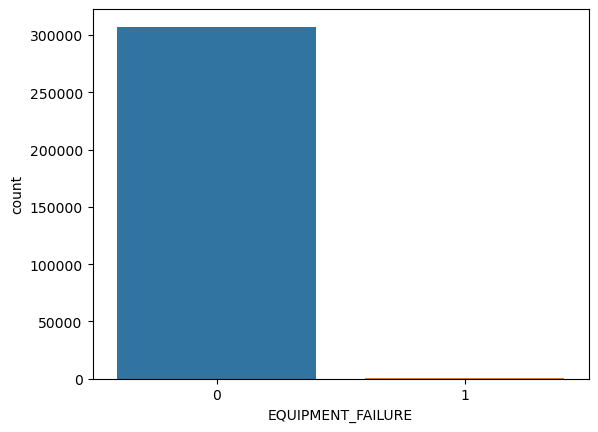

In [48]:
y = df['EQUIPMENT_FAILURE']
print(y.value_counts())
ax = sns.countplot(x=y)

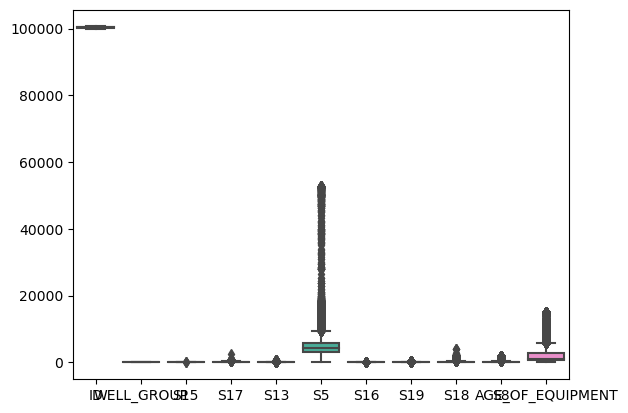

In [49]:
sns.boxplot(X)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
{0: 9900, 1: 100}


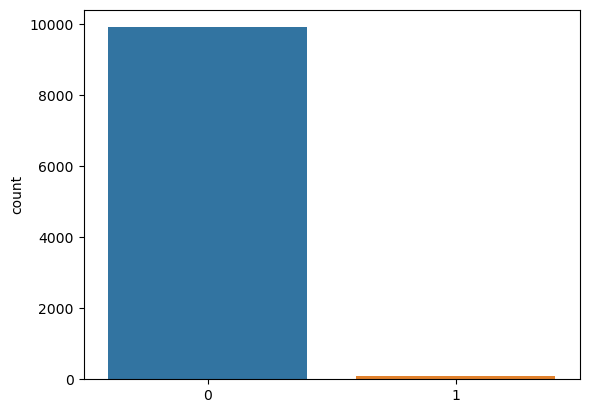

In [7]:
# grid search positive class weights with xgboost for imbalance classification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=2, weights=[0.99], flip_y=0, random_state=7)

print(type(X), type(y))
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
sns.countplot(x=y)

Class distribution (y_train):  {0: 7425, 1: 75}
Class distribution (y_test):  {0: 2475, 1: 25}


Text(0.5, 1.0, 'Test dataset')

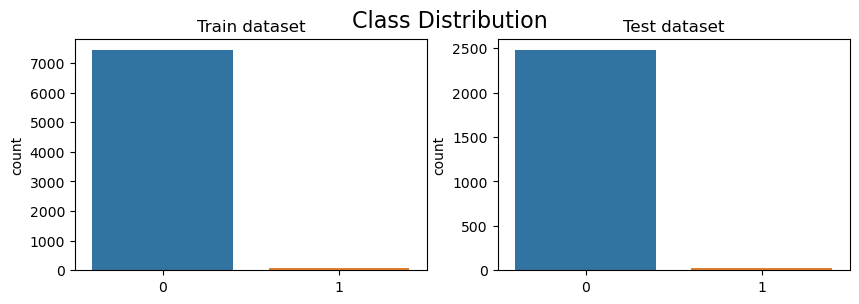

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution (y_train): ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Class distribution (y_test): ", dict(zip(unique, counts)))

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Class Distribution', fontsize=16)
sns.countplot(ax=axes[0], x=y_train)
axes[0].set_title("Train dataset")
sns.countplot(ax=axes[1], x=y_test)
axes[1].set_title("Test dataset")

In [29]:
# define model
model = XGBClassifier()
# define grid
weights = [0, 0.5, 1, 5, 10, 25, 50]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.947120 using {'scale_pos_weight': 5}
0.500000 (0.000000) with: {'scale_pos_weight': 0}
0.937962 (0.033750) with: {'scale_pos_weight': 0.5}
0.939587 (0.035758) with: {'scale_pos_weight': 1}
0.947120 (0.032548) with: {'scale_pos_weight': 5}
0.942173 (0.038889) with: {'scale_pos_weight': 10}
0.938155 (0.037712) with: {'scale_pos_weight': 25}
0.937531 (0.036145) with: {'scale_pos_weight': 50}


In [30]:
y_pred = grid.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      2475
     class 1       0.42      0.32      0.36        25

    accuracy                           0.99      2500
   macro avg       0.71      0.66      0.68      2500
weighted avg       0.99      0.99      0.99      2500

[[2464   11]
 [  17    8]]
Area Under Curve: 0.6577777777777778


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate_model(alg, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(predictors, target, eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(predictors)
    dtrain_predprob = alg.predict_proba(predictors)[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target, dtrain_predprob))

In [19]:
# Define the parameter values for a xgbt model

estimator_vals=160
lr_vals = 0.8
md_vals = 12
mcw_vals = 0.5
gamma_vals =.1
subsample_vals = .5
c_bt_vals = 1
reg_lambda_vals = 1
reg_alpha_vals = 1

In [20]:
# Define the model

xgb0 = XGBClassifier(objective = 'binary:logistic',use_label_encoder=False,learning_rate = lr_vals,
n_estimators=estimator_vals,max_depth=md_vals,min_child_weight=mcw_vals,
gamma=gamma_vals,subsample=subsample_vals,colsample_bytree=c_bt_vals,
reg_lambda=reg_lambda_vals,reg_alpha=reg_alpha_vals);

C:\Users\DAD\anaconda3\envs\mlenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 1
AUC Score (Balanced): 1.000000


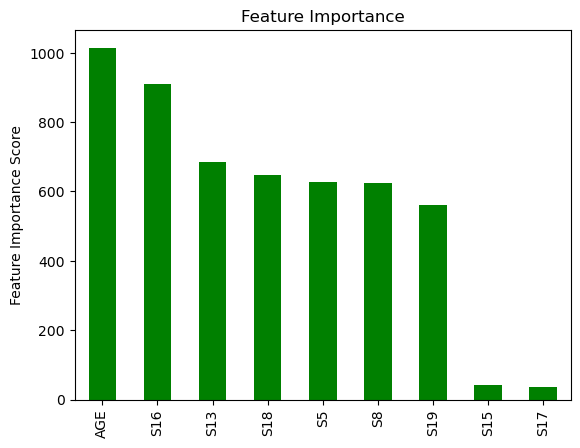

In [21]:
# Build the model on the balanced training data set.
independent = y
dependent = X
evaluate_model(xgb0, independent, dependent) 